<a href="https://colab.research.google.com/github/gabrielesartor/CSPInterpreter/blob/master/autoencoder_treasure_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder for the treasure game
A simple experiment on autoencoders using Keras.

This example has been created modifying the code available on "The Keras Blog" at https://blog.keras.io/building-autoencoders-in-keras.html

In [16]:
import os
print(os.getcwd())

/content


In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6311127552811694632
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1328901554891704447
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [18]:
import keras
from keras import layers, regularizers

# This is the size of our encoded representations
latent_dim = 400  # 400 floats 

encoder_inputs = keras.Input(shape=(336, 312, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-5))(encoder_inputs)
x = layers.Dropout(0.4)(x)
x = layers.AveragePooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Dropout(0.4)(x)
x = layers.AveragePooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(latent_dim, activation="sigmoid")(x)


In [19]:
x = layers.Dense(84 * 78 * 32, activation="relu")(encoded)
x = layers.Reshape((84, 78, 32))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Dropout(0.4)(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Dropout(0.4)(x)
x = layers.UpSampling2D((2, 2))(x)
decoder_outputs = layers.Conv2D(3, 3, activation="relu", padding="same")(x)


In [20]:
autoencoder = keras.Model(encoder_inputs, decoder_outputs)
autoencoder.compile(optimizer='adam', loss="mean_squared_error")
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 336, 312, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 336, 312, 32)      896       
_________________________________________________________________
dropout_4 (Dropout)          (None, 336, 312, 32)      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 168, 156, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 168, 156, 16)      4624      
_________________________________________________________________
dropout_5 (Dropout)          (None, 168, 156, 16)      0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 84, 78, 16)        0   

In [21]:
import numpy as np
import tensorflow as tf

dataset = keras.preprocessing.image_dataset_from_directory("sample_data/treasure_game_images",
                                                        label_mode = None,
                                                        color_mode = "rgb",
                                                        image_size = (336, 312),
                                                        batch_size = 1
                                                        )

X_data = []
for data in dataset:
  X_data.append(data[0].numpy())
X_data = np.array(X_data)  
X_data.shape
Y_data = np.copy(X_data)
print(X_data.dtype)

Found 299 files belonging to 2 classes.
float32


In [22]:
autoencoder.fit(x=X_data,
                y=Y_data,
                epochs = 800)

Epoch 1/800
10/10 [==============================] - 3s 211ms/step - loss: 6268.1487
Epoch 2/800
10/10 [==============================] - 2s 211ms/step - loss: 3126.9424
Epoch 3/800
10/10 [==============================] - 2s 214ms/step - loss: 1782.9057
Epoch 4/800
10/10 [==============================] - 2s 216ms/step - loss: 1403.3978
Epoch 5/800
10/10 [==============================] - 2s 217ms/step - loss: 1178.5594
Epoch 6/800
10/10 [==============================] - 2s 217ms/step - loss: 1013.6279
Epoch 7/800
10/10 [==============================] - 2s 215ms/step - loss: 868.4426
Epoch 8/800
10/10 [==============================] - 2s 217ms/step - loss: 788.0148
Epoch 9/800
10/10 [==============================] - 2s 217ms/step - loss: 717.0741
Epoch 10/800
10/10 [==============================] - 2s 219ms/step - loss: 670.5046
Epoch 11/800
10/10 [==============================] - 2s 217ms/step - loss: 638.9611
Epoch 12/800
10/10 [==============================] - 2s 217ms/step 

In [23]:
decode_images = autoencoder.predict(X_data)

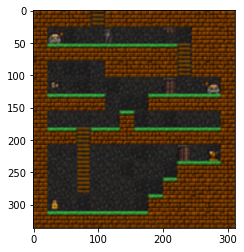

In [24]:
import matplotlib.pyplot as plt
plt.imshow(decode_images[0].astype(np.uint8))

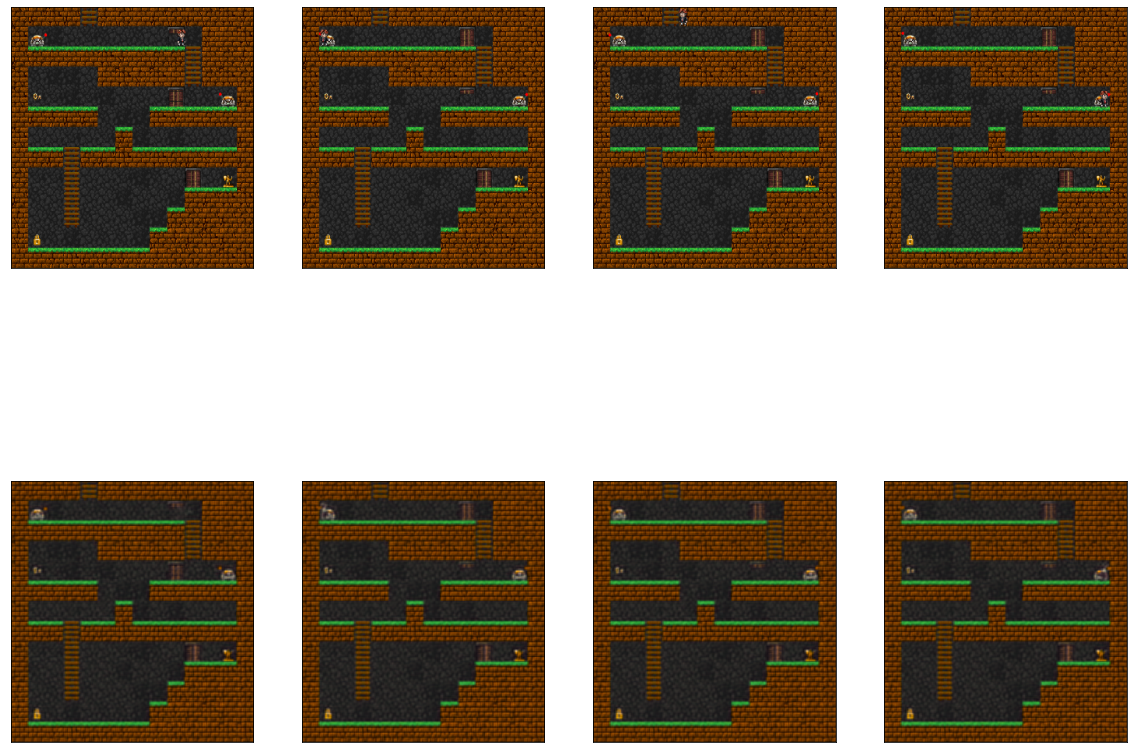

In [25]:
n = 4
plt.figure(figsize=(20, 16))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_data[i].astype(np.uint8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decode_images[i].astype(np.uint8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [26]:
encoder = keras.Model(encoder_inputs, encoded)
encoded_imgs = encoder.predict(X_data)

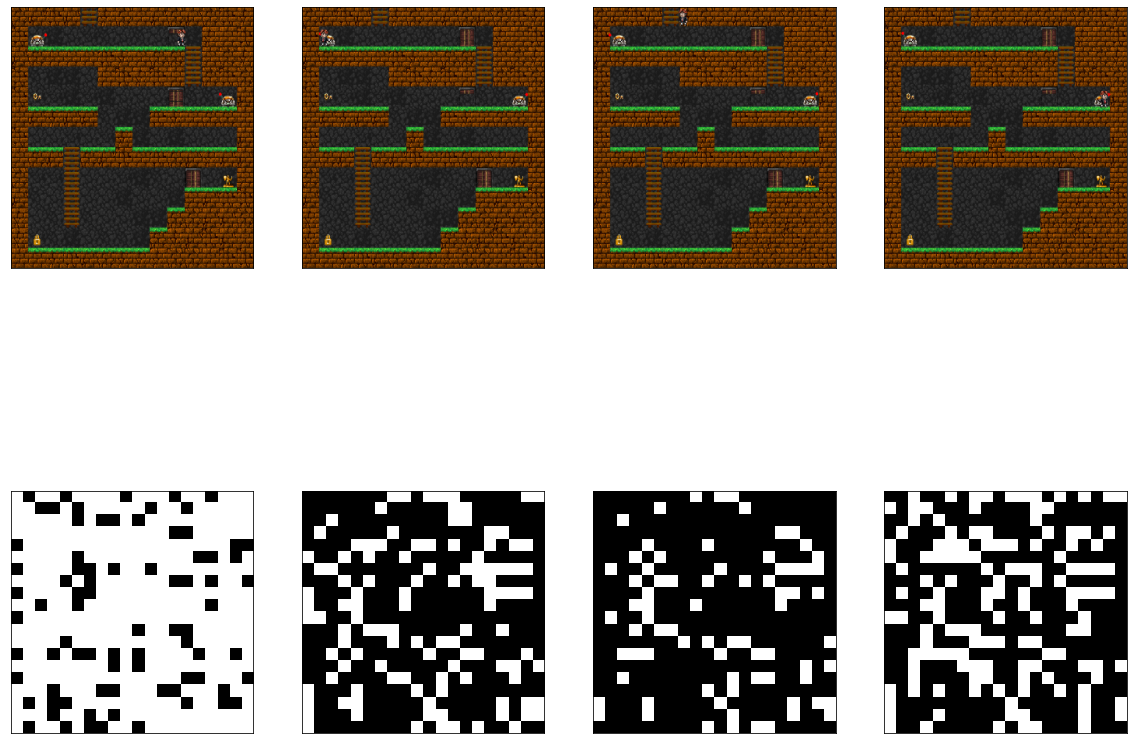

In [27]:
n = 4
plt.figure(figsize=(20, 16))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_data[i].astype(np.uint8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(encoded_imgs[i].reshape(20,20).astype(np.uint8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()